In [1]:
import pandas as pd 
import numpy as np 
import string
import nltk 
import re
import joblib
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, log_loss, plot_confusion_matrix

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
vect_path = 'models/tfvectorizer.sav'
clf_path = 'models/logistic_regression_tf.sav'
data_path = "data/test.csv"

In [2]:
test = pd.read_csv(data_path)

In [3]:
test = test.dropna(axis=0, how="any")

In [4]:
test = test[['reviewText', 'summary', 'score']]

In [5]:
def convert_and_prepare_data(df : pd.DataFrame) -> pd.DataFrame:
    newdf = df.copy()
    # prepare text, delete punctuation and stop words
    newdf['tokenized'] = newdf.reviewText.apply(lambda x : word_tokenize(x))
    newdf['tokenized'] = newdf['tokenized'].apply(lambda x : np.array([word for word in x if word.isalnum()]) )
    newdf['tokenized'] = newdf['tokenized'].apply(lambda x : np.array([word for word in x if word not in STOP_WORDS]) )
    # lemmatizing and stemming
    ps = PorterStemmer()
    wnl = WordNetLemmatizer()
    newdf['tokenized'] = newdf['tokenized'].apply(lambda x : np.array([wnl.lemmatize(ps.stem(i.lower())) for i in x]) )
    #count final words number
    newdf['count_words'] = newdf['tokenized'].apply(lambda x : len(x))
    # delete recurring words - to check
    newdf['unique_words'] = newdf['tokenized'].apply(lambda x : np.unique(x))
    # create text from words 
    newdf['new_text'] = newdf['unique_words'].apply(lambda x : ' '.join(x))
    return newdf

In [6]:
testDf = convert_and_prepare_data(test)

In [8]:
vect = joblib.load(vect_path)

In [9]:
testTF = vect.transform(testDf['new_text'])

In [12]:
def test_model(filename, X_train, y_train):
    
    clf = joblib.load(filename)
    y_train_pred = clf.predict(X_train)
    class_report = classification_report(y_train,y_train_pred)
    
    cm = confusion_matrix(y_train,y_train_pred)
    fig = plt.figure()
    plot_confusion_matrix(clf, X_train, y_train, values_format = '.5g')
    plt.savefig(f"metrics/{filename[12:-4]}.png")

    acc = accuracy_score(y_train,y_train_pred)
    f1 = f1_score(y_train,y_train_pred, average='macro')
    #loss = log_loss(y_train, y_train_pred)
  
    
    print("Confusion matrix")
    print(cm)
    print("_"*50)
    print("REPORT: ")
    print(class_report)
    print("Accuracy score: {}%".format(round(acc,2)*100))
    print("F1 score: {}".format(f1))
    #print("Cross entropy loss: {}".format(loss))

    return acc, f1

Confusion matrix
[[10232   533  1009   789  2455]
 [ 2588  1252  1510  1079  2005]
 [ 1787   585  4843  3489  5310]
 [  948   199  1700  9700 16663]
 [ 1314   157   962  4845 62987]]
__________________________________________________
REPORT: 
              precision    recall  f1-score   support

         1.0       0.61      0.68      0.64     15018
         2.0       0.46      0.15      0.22      8434
         3.0       0.48      0.30      0.37     16014
         4.0       0.49      0.33      0.40     29210
         5.0       0.70      0.90      0.79     70265

    accuracy                           0.64    138941
   macro avg       0.55      0.47      0.48    138941
weighted avg       0.61      0.64      0.61    138941

Accuracy score: 64.0%
F1 score: 0.48440797540069036


(0.6406604242088368, 0.48440797540069036)

<Figure size 432x288 with 0 Axes>

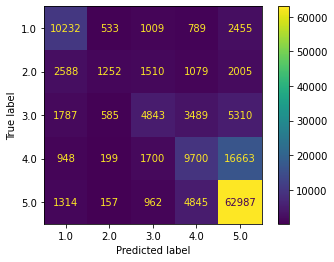

In [16]:
test_model(clf_path, testTF, testDf['score'])